In [1]:
%matplotlib notebook

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output, display
from scipy.ndimage import gaussian_filter
from scipy.spatial import distance
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans
import multiprocessing
from functools import partial
import time
import os
from os.path import join
import re

import wolff
import wolff_cross

# Track calculation errors
np.seterr('raise')

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [2]:
start_path = '/Users/share/Chiel4Loran/FFxRECxNOISE'
pat_neuro = re.compile(r"neuro_mem")

neuro_prefix = "neuro_mem"
angle_prefix = "initial_angles"

files = []
params = []
paths_prepared = []

for (dirpath, dirnames, filenames) in os.walk(start_path):
    neuro_files = list(filter(pat_neuro.match, filenames))
    _params = [pat_neuro.sub("", file) for file in neuro_files]
    files += [(join(dirpath, neuro_prefix+param), join(dirpath, angle_prefix+param)) for param in _params]
    params += _params
    
params = [re.sub(r"(^_)|(\.npy)", "", param) for param in params]
params_txt = [re.sub(r"_", " ", param) for param in params]
params_txt = [re.sub(r",", ".", param) for param in params_txt]

paths_prepared = [join('/Users/s3182541/STSP/Decoding/data/FFxRECxNOISE', param) for param in params]

files, params, params_txt, paths_prepared = zip(*sorted(zip(
    files, 
    params, 
    params_txt, 
    paths_prepared), key=lambda tup: tup[3]))

In [3]:
path = paths_prepared[8]
c = np.load(join(path, "c.npy"))

In [4]:
wolff_path = '/Users/s3182541/STSP/Decoding/data/wolff'
c_early = np.load(join(wolff_path, 'c_early.npy'))
c_late = np.load(join(wolff_path, 'c_late.npy'))
time_wolff = np.load(join(wolff_path, 'time_wolff.npy'))

<IPython.core.display.Javascript object>


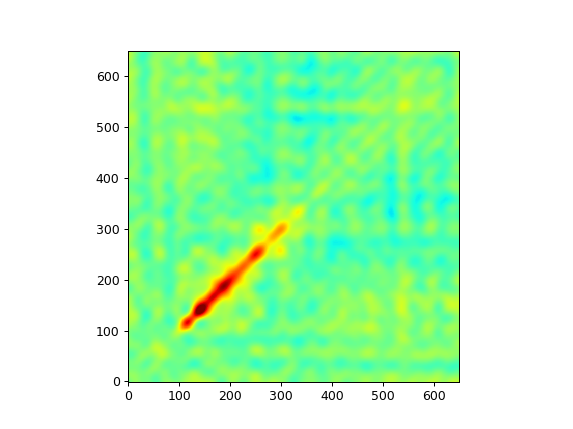

In [5]:
plt.close()

extents = [time_wolff[0], time_wolff[-1], time_wolff[0], time_wolff[-1]]
# plt.imshow(c_late, cmap='jet', origin='lower', vmin=-1e-3, vmax=1e-3, extent=extents)
plt.imshow(c_late, cmap='jet', origin='lower', vmin=-1e-3, vmax=1e-3)

In [6]:
num_include = len(time_wolff[time_wolff >= 0.050])
c_early = c_early[-num_include:, -num_include:]
c_late = c_late[-num_include:, -num_include:]

In [4]:
num_include

575

In [7]:
f_interp = scipy.interpolate.RectBivariateSpline(np.arange(c.shape[0]), np.arange(c.shape[1]), c)

<IPython.core.display.Javascript object>


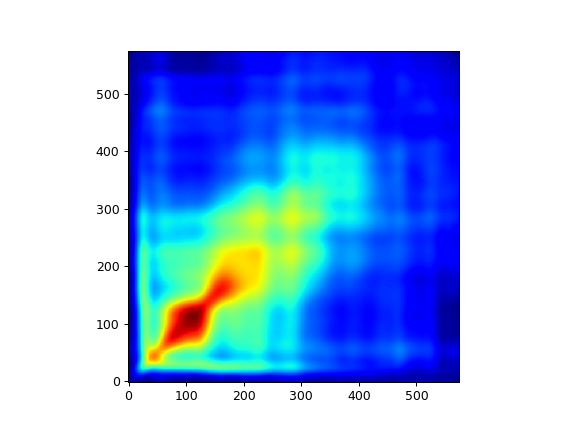

In [8]:
plt.close()

w_steps = c_early.shape[0]
steps = np.linspace(0, c.shape[0], w_steps) # From 0 to end of c with w_steps number of steps
c_sparse = f_interp(steps, steps)
z = (c_sparse - c_sparse.mean()) / c_sparse.std()
z = gaussian_filter((z + z.T) / 2, sigma=8)
        
plt.imshow(z, cmap='jet', origin='lower')

In [9]:
arr = np.random.normal(0, 1, size=(w_steps, w_steps))

<IPython.core.display.Javascript object>


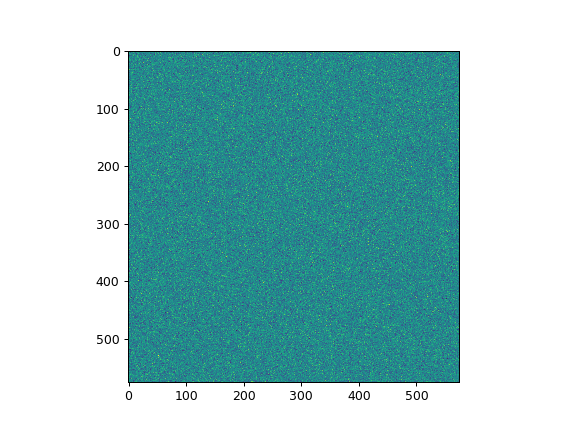

In [11]:
plt.close()

z = (arr - arr.mean()) / arr.std()
z = gaussian_filter((z + z.T) / 2, sigma=8)

plt.imshow(arr)

0.010006120630869714


<IPython.core.display.Javascript object>


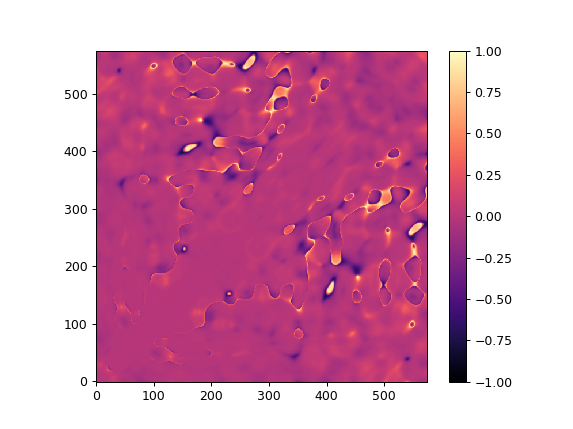

In [12]:
plt.close()

z_early = (c_early - c_early.mean()) / c_early.std()
sim, full_im = ssim(z_early, 
                    z, 
                    gaussian_weights=True, 
                    sigma=1.5, 
                    use_sample_covariance=False,
                    full=True)
print(sim)
plt.imshow(full_im, cmap='magma', origin='lower', vmin=-1, vmax=1)
plt.colorbar()

<IPython.core.display.Javascript object>


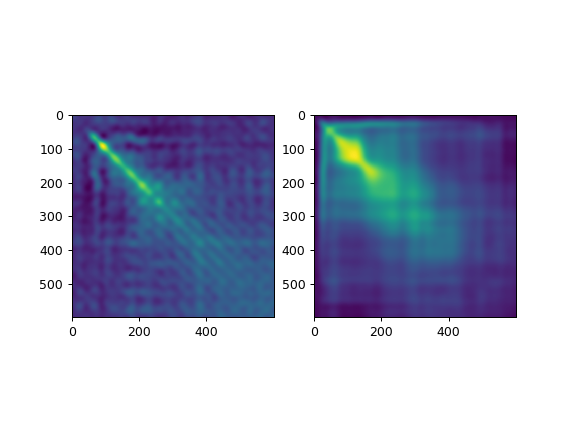

In [66]:
plt.close()

fig = plt.figure()

ax = fig.add_subplot(121)
ax.imshow(z_early)

ax = fig.add_subplot(122)
ax.imshow(z)

plt.show()

<IPython.core.display.Javascript object>


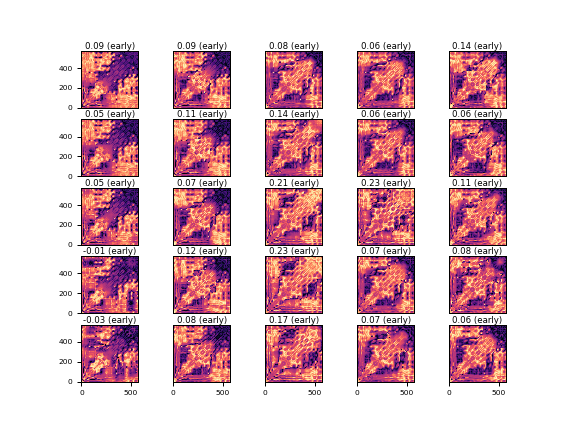

In [58]:
nrow = 5
ncol = 5
left_i = [i for i in range(nrow * ncol) if i % ncol == 0]
bottom_i = list(range(nrow * ncol - ncol, nrow * ncol))
save_path = '/Users/s3182541/STSP/Decoding/data/FFxRECxNOISE'

tups = np.array(list(zip(paths_prepared, params_txt)))
tups = tups.reshape((5, 5, 2))
tups = tups.transpose((1, 0, 2))
tups = tups[:, [2, 1, 3, 0, 4], :]
tups = tups.reshape((25, 2))

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    
    # Interpolation function for c
    f_interp = scipy.interpolate.RectBivariateSpline(np.arange(c.shape[0]), np.arange(c.shape[1]), c)
    # The number of steps in the Wolff data
    w_steps = c_early.shape[0]
    # From 0 to end of c with w_steps number of steps
    steps = np.linspace(0, c.shape[0], w_steps)
    # Interpolate c, with steps functioning as row and column coordinates
    c_sparse = f_interp(steps, steps)
    
    # Calculate z-scores
    z = (c_sparse - c_sparse.mean()) / c_sparse.std()
    z = gaussian_filter((z + z.T) / 2, sigma=8)
    
    # Calculate similarity between model's and Wolff's z-scores
    sim, full_im = ssim(z_early, 
                        z, 
                        gaussian_weights=True, 
                        sigma=1.5, 
                        use_sample_covariance=False,
                        full=True)
    
    ax = fig.add_subplot(nrow, ncol, i + 1)
    ax.set_title('{:.2f} (early)'.format(sim), fontsize='x-small', va='top')
    ax.tick_params(axis='both', which='major', labelsize=6)
    if not i in left_i:
        plt.yticks([])
    if not i in bottom_i:
        plt.xticks([])
    ax.imshow(full_im, cmap='magma', origin='lower', vmin=-1, vmax=1)
    
plt.savefig(join(save_path, 'ssims_early.pdf'), dpi=300, format='pdf')

<IPython.core.display.Javascript object>


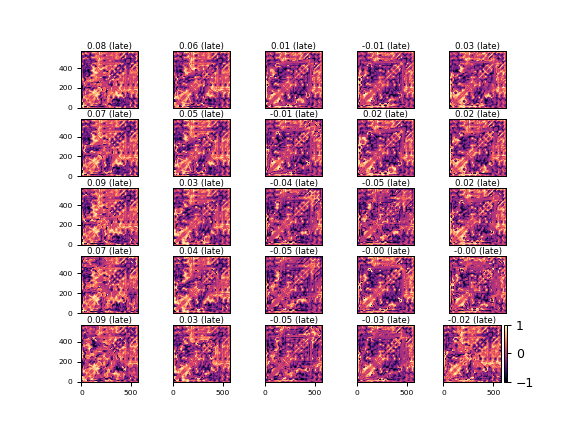

In [59]:
nrow = 5
ncol = 5
left_i = [i for i in range(nrow * ncol) if i % ncol == 0]
bottom_i = list(range(nrow * ncol - ncol, nrow * ncol))
save_path = '/Users/s3182541/STSP/Decoding/data/FFxRECxNOISE'

tups = np.array(list(zip(paths_prepared, params_txt)))
tups = tups.reshape((5, 5, 2))
tups = tups.transpose((1, 0, 2))
tups = tups[:, [2, 1, 3, 0, 4], :]
tups = tups.reshape((25, 2))

z_late = (c_late - c_late.mean()) / c_late.std()

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    
    # Interpolation function for c
    f_interp = scipy.interpolate.RectBivariateSpline(np.arange(c.shape[0]), np.arange(c.shape[1]), c)
    # The number of steps in the Wolff data
    w_steps = c_late.shape[0]
    # From 0 to end of c with w_steps number of steps
    steps = np.linspace(0, c.shape[0], w_steps)
    # Interpolate c, with steps functioning as row and column coordinates
    c_sparse = f_interp(steps, steps)
    
    # Calculate z-scores
    z = (c_sparse - c_sparse.mean()) / c_sparse.std()
    z = gaussian_filter((z + z.T) / 2, sigma=8)
    
    # Calculate similarity between model's and Wolff's z-scores
    sim, full_im = ssim(z_late, 
                        z, 
                        gaussian_weights=True, 
                        sigma=1.5, 
                        use_sample_covariance=False,
                        full=True)
    
    ax = fig.add_subplot(nrow, ncol, i + 1)
    ax.set_title('{:.2f} (late)'.format(sim), fontsize='x-small', va='top')
    ax.tick_params(axis='both', which='major', labelsize=6)
    if not i in left_i:
        plt.yticks([])
    if not i in bottom_i:
        plt.xticks([])
    ax.imshow(full_im, cmap='magma', origin='lower', vmin=-1, vmax=1)
    
plt.savefig(join(save_path, 'ssims_late.pdf'), dpi=300, format='pdf')

In [33]:
sweep_path = '/Users/s3182541/STSP/Decoding/data/sweep'
pat_probe = re.compile(r"probe")
params = []
for (dirpath, dirnames, filenames) in os.walk(sweep_path):
    _params = list(filter(pat_probe.match, dirnames))
    params += _params
    
params = [re.sub(r"(^_)|(\.npy)", "", param) for param in params]
params_txt = [re.sub(r"_", " ", param) for param in params]
params_txt = [re.sub(r",", ".", param) for param in params_txt]

paths_prepared = [join('/Users/s3182541/STSP/Decoding/data/sweep', param) for param in params]

params, params_txt, paths_prepared = zip(*sorted(zip(
    params, 
    params_txt, 
    paths_prepared), key=lambda tup: tup[2]))

<IPython.core.display.Javascript object>


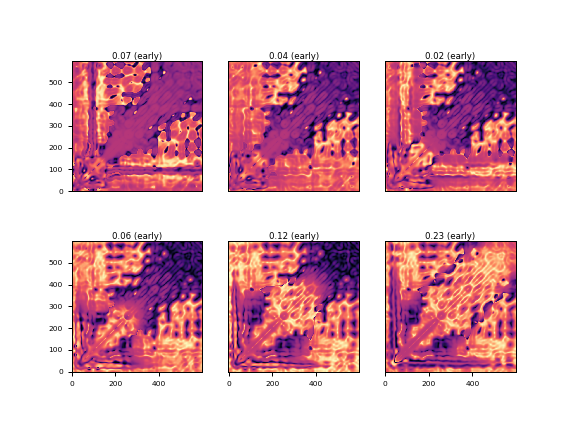

In [34]:
nrow = 2
ncol = 3
left_i = [i for i in range(nrow * ncol) if i % ncol == 0]
bottom_i = list(range(nrow * ncol - ncol, nrow * ncol))
save_path = '/Users/s3182541/STSP/Decoding/data/sweep'

# tups = np.array(list(zip(paths_prepared, params_txt)))
# tups = tups.reshape((5, 5, 2))
# tups = tups.transpose((1, 0, 2))
# tups = tups[:, [2, 1, 3, 0, 4], :]
# tups = tups.reshape((25, 2))
tups = list(zip(paths_prepared, params_txt))

plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    
    # Interpolation function for c
    f_interp = scipy.interpolate.RectBivariateSpline(np.arange(c.shape[0]), np.arange(c.shape[1]), c)
    # The number of steps in the Wolff data
    w_steps = c_early.shape[0]
    # From 0 to end of c with w_steps number of steps
    steps = np.linspace(0, c.shape[0], w_steps)
    # Interpolate c, with steps functioning as row and column coordinates
    c_sparse = f_interp(steps, steps)
    
    # Calculate z-scores
    z = (c_sparse - c_sparse.mean()) / c_sparse.std()
    z = gaussian_filter((z + z.T) / 2, sigma=8)
    
    # Calculate similarity between model's and Wolff's z-scores
    sim, full_im = ssim(z_early, 
                        z, 
                        gaussian_weights=True, 
                        sigma=1.5, 
                        use_sample_covariance=False,
                        full=True)
    
    ax = fig.add_subplot(nrow, ncol, i + 1)
    ax.set_title('{:.2f} (early)'.format(sim), fontsize='x-small', va='top')
    ax.tick_params(axis='both', which='major', labelsize=6)
    if not i in left_i:
        plt.yticks([])
    if not i in bottom_i:
        plt.xticks([])
    ax.imshow(full_im, cmap='magma', origin='lower', vmin=-1, vmax=1)
    
plt.savefig(join(save_path, 'ssims_early.pdf'), dpi=300, format='pdf')

<IPython.core.display.Javascript object>


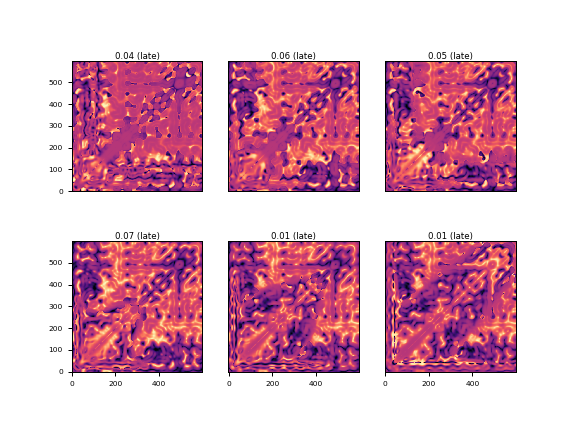

In [35]:
plt.close()
fig = plt.figure()

for i, (path, param_txt) in enumerate(tups):
    c = np.load(join(path, "c.npy"))
    
    # Interpolation function for c
    f_interp = scipy.interpolate.RectBivariateSpline(np.arange(c.shape[0]), np.arange(c.shape[1]), c)
    # The number of steps in the Wolff data
    w_steps = c_late.shape[0]
    # From 0 to end of c with w_steps number of steps
    steps = np.linspace(0, c.shape[0], w_steps)
    # Interpolate c, with steps functioning as row and column coordinates
    c_sparse = f_interp(steps, steps)
    
    # Calculate z-scores
    z = (c_sparse - c_sparse.mean()) / c_sparse.std()
    z = gaussian_filter((z + z.T) / 2, sigma=8)
    
    # Calculate similarity between model's and Wolff's z-scores
    sim, full_im = ssim(z_late, 
                        z, 
                        gaussian_weights=True, 
                        sigma=1.5, 
                        use_sample_covariance=False,
                        full=True)
    
    ax = fig.add_subplot(nrow, ncol, i + 1)
    ax.set_title('{:.2f} (late)'.format(sim), fontsize='x-small', va='top')
    ax.tick_params(axis='both', which='major', labelsize=6)
    if not i in left_i:
        plt.yticks([])
    if not i in bottom_i:
        plt.xticks([])
    ax.imshow(full_im, cmap='magma', origin='lower', vmin=-1, vmax=1)
    
plt.savefig(join(save_path, 'ssims_late.pdf'), dpi=300, format='pdf')

0.09279308794678219


<IPython.core.display.Javascript object>


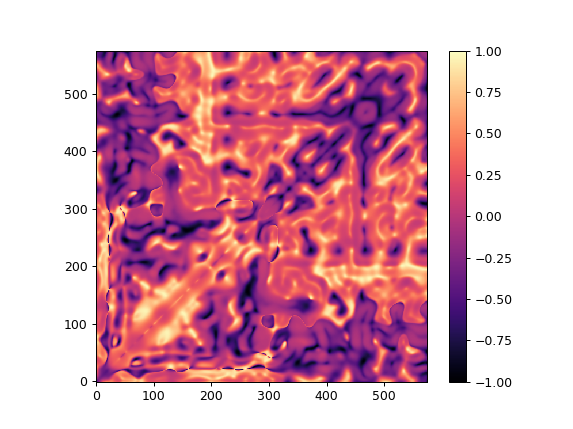

In [6]:
plt.close()

c = np.load('/Users/s3182541/STSP/Decoding/data/testmodels/model4/c.npy')

# Interpolation function for c
f_interp = scipy.interpolate.RectBivariateSpline(np.arange(c.shape[0]), np.arange(c.shape[1]), c)
# The number of steps in the Wolff data
w_steps = c_late.shape[0]
# From 0 to end of c with w_steps number of steps
steps = np.linspace(0, c.shape[0], w_steps)
# Interpolate c, with steps functioning as row and column coordinates
c_sparse = f_interp(steps, steps)

# Calculate z-scores
z = (c_sparse - c_sparse.mean()) / c_sparse.std()
z = gaussian_filter((z + z.T) / 2, sigma=8)

z_late = (c_late - c_late.mean()) / c_late.std()

# Calculate similarity between model's and Wolff's z-scores
sim, full_im = ssim(z_late, 
                    z, 
                    gaussian_weights=True, 
                    sigma=1.5, 
                    use_sample_covariance=False,
                    full=True)

print(sim)
plt.imshow(full_im, cmap='magma', origin='lower', vmin=-1, vmax=1)
plt.colorbar()

<IPython.core.display.Javascript object>


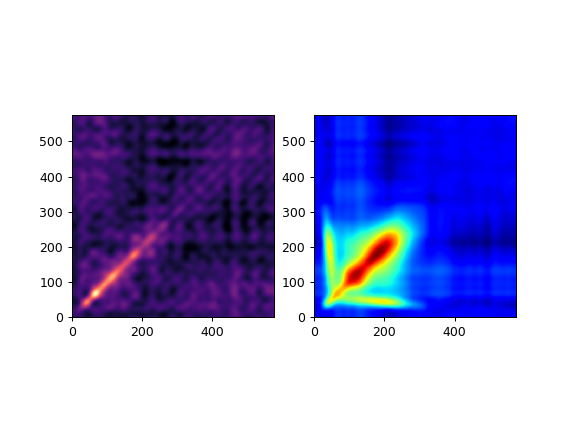

In [7]:
plt.close()

fig = plt.figure()

ax = fig.add_subplot(121)
ax.imshow(z_late, cmap='magma', origin='lower')

ax = fig.add_subplot(122)
ax.imshow(z, cmap='jet', origin='lower')

<IPython.core.display.Javascript object>


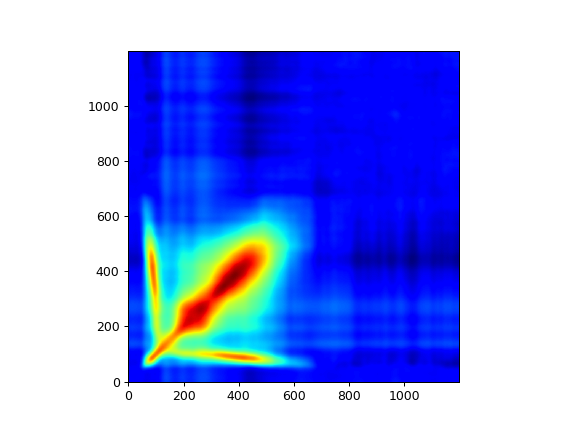

In [85]:
c_transformed = (c + c.T) / 2
filtered = gaussian_filter(c_transformed, sigma=8)
plt.close()
plt.imshow(filtered, cmap='jet', origin='lower')

In [4]:
# This code does not belong here
dat = scipy.io.loadmat('wolff/cross_exp1.mat')
dec_mem = dat['dec_mem']
time = np.squeeze(dat['time'])

In [5]:
dec_mem = dec_mem.mean(axis=0)

<IPython.core.display.Javascript object>


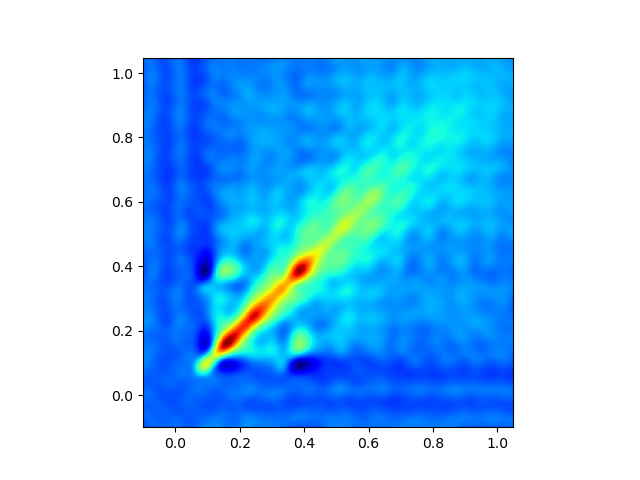

In [15]:
plt.close()

extent = [time[0], time[-1], time[0], time[-1]]
plt.imshow(dec_mem, cmap='jet', origin='lower', extent=extent)

<IPython.core.display.Javascript object>


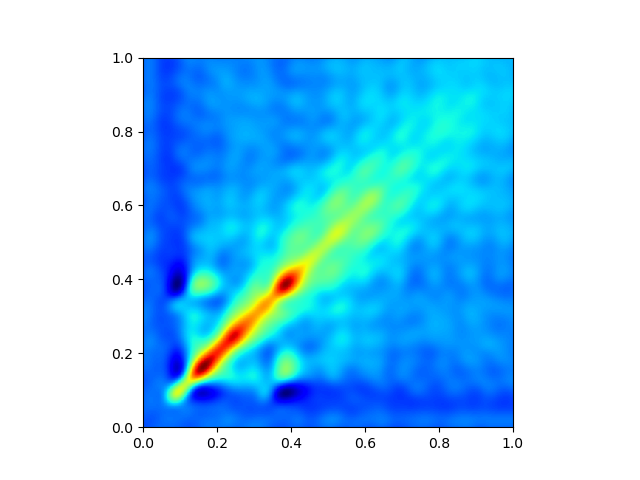

In [16]:
plt.close()

dec_cut = dec_mem[np.logical_and(time >= 0, time <= 1), :]
dec_cut = dec_cut[:, np.logical_and(time >= 0, time <= 1)]
plt.imshow(dec_cut, cmap='jet', origin='lower', extent=[0, 1, 0, 1])

In [17]:
z = (dec_cut - dec_cut.mean()) / dec_cut.std()
np.save('figures/data/z_exp1_cross_wolff.npy', z)